<a href="https://colab.research.google.com/github/clashleyuncc/Intro-To-ML/blob/main/Final-Project/MLProjectFCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

# Use of Logistic Regression to classify UC Irvine's
# "Steel Industry Energy Consumption" dataset into Light, Medium,
# and Maximum load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict
import time

#torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        t_u_train_device = t_u_train.to(device)
        t_c_train_device = t_c_train.to(device)

        t_p_train = model(t_u_train_device)
        loss_train = loss_fn(t_p_train, t_c_train_device)

        t_u_val_device = t_u_val.to(device)
        t_c_val_device = t_c_val.to(device)

        t_p_val = model(t_u_val_device)
        loss_val = loss_fn(t_p_val, t_c_val_device)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        if epoch == 1 or epoch % 500 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              time.time()-start_time, epoch, loss_train.item(), loss_val.item()))

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Analyze energy consumption by day of the week
if 'Day_of_week' in X.columns:
    energy_by_day = X.groupby('Day_of_week')['Usage_kWh'].sum().reset_index()
    energy_by_day = energy_by_day.sort_values(by='Usage_kWh', ascending=False)
    print("\nEnergy Consumption by Day of the Week:")
    print(energy_by_day)

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')
# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

t_c = y
#t_u = X
t_c = torch.tensor(t_c)
t_u = torch.tensor(X.to_numpy())

t_u = t_u.to(torch.float32).to(device)
#t_c = t_c.to(torch.float32).to(device)
t_c = t_c.to(torch.long).to(device)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

train_losses = []
val_losses = []

seq_model = nn.Sequential(OrderedDict([
            ('hidden_linear1', nn.Linear(14, 254)),
            ('hidden_activation1', nn.Tanh()),
            #('hidden_linear2', nn.Linear(254, 8)),
            #('hidden_activation2', nn.Tanh()),
            ('output_linear', nn.Linear(254,3))
]))

numel_list = [p.numel() for p in seq_model.parameters()]
print(sum(numel_list))
print(numel_list)

seq_model.to(device)
optimizer = optim.SGD(seq_model.parameters(), lr=1e-5)
start_time = time.time()

training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = seq_model,
    #loss_fn = nn.MSELoss(),
    loss_fn = nn.CrossEntropyLoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
  plt.plot(train_losses_cpu, label="Training Loss")
  plt.plot(val_losses_cpu, label="Validation Loss")
  plt.xlabel("Iteration")
  #plt.ylabel("Mean Squared Error")
  plt.ylabel("Cross Entropy Loss")
  plt.legend()
  plt.title("Training and Validation Loss Over Iterations")
  plt.show()


seq_model.eval()

with torch.no_grad():
    t_u_val = t_u_val.to(device)
    predictions = seq_model(t_u_val)
    predicted_classes = torch.argmax(predictions, dim=1)

t_c_val = t_c_val.cpu().numpy()
predicted_classes = predicted_classes.cpu().numpy()

matrix = confusion_matrix(t_c_val, predicted_classes)
cnf_matrix = confusion_matrix(t_c_val, predicted_classes)
report = classification_report(t_c_val, predicted_classes)
print(report)

##

class_names=['Light','Medium','Maximum'] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g',
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()


Using device: cuda

Energy Consumption by Day of the Week:
  Day_of_week  Usage_kWh
4    Thursday  175279.52
5     Tuesday  171862.65
1      Monday  168636.34
0      Friday  165709.51
6   Wednesday  161013.14
2    Saturday   79467.75
3      Sunday   37667.80
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
4575
[3556, 254, 762, 3]
Esimated run time for 1000 Epoch: 0.438 minutes
0.026447296142578125 Seconds, Epoch 1, Training Loss 1.087921380996704, Validation Loss 1.0884981155395508


KeyboardInterrupt: 

In [18]:
torch.cuda.empty_cache()

Using device: cuda
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
Esimated run time for 100 Epoch: 1.215 minutes
0.7291107177734375 Seconds, Epoch 1, Training Loss 1.047243595123291, Validation Loss 1.014032244682312
Epoch 1, Training Loss: 1.0483, Validation Loss: 1.0408
7.231247663497925 Seconds, Epoch 10, Training Loss 0.9596732258796692, Validation Loss 0.8944998383522034
Epoch 10, Training Loss: 0.9446, Validation Loss: 0.9367
14.463228940963745 Seconds, Epoch 20, Training Loss 0.8119248747825623, Validation Loss 0.8025792837142944
Epoch 20, Training Loss: 0.8637, Validation Loss: 0.8555
21.644042491912842 Seconds, Epoch 30, Training Loss 0.7875895500183105, Validation Loss 0.7397092580795288
Epoch 30, Training Loss: 0.8072, Validation Loss: 0.7989
28.907205820083618 Seconds, Epoch 40, Training Loss 0.8247117400169373, Validation Loss 0.6956645250320435
Epoch 40, Training Loss: 0.7668, Validation Loss: 0.7583
36.07912874221802 Seconds, Epoch 50, Training Loss 0.737878

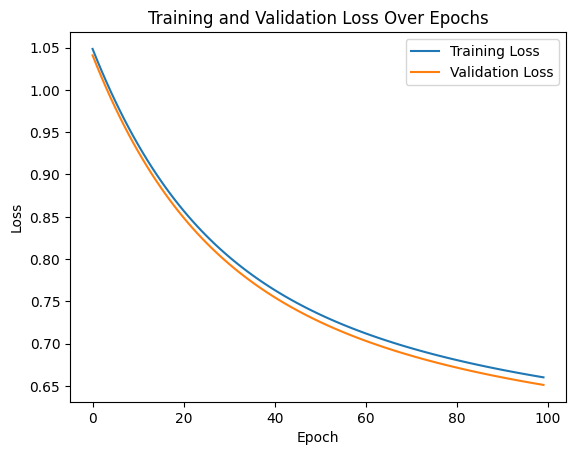

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3652
           1       0.52      0.74      0.61      1429
           2       0.62      0.47      0.53      1927

    accuracy                           0.73      7008
   macro avg       0.68      0.69      0.67      7008
weighted avg       0.74      0.73      0.73      7008



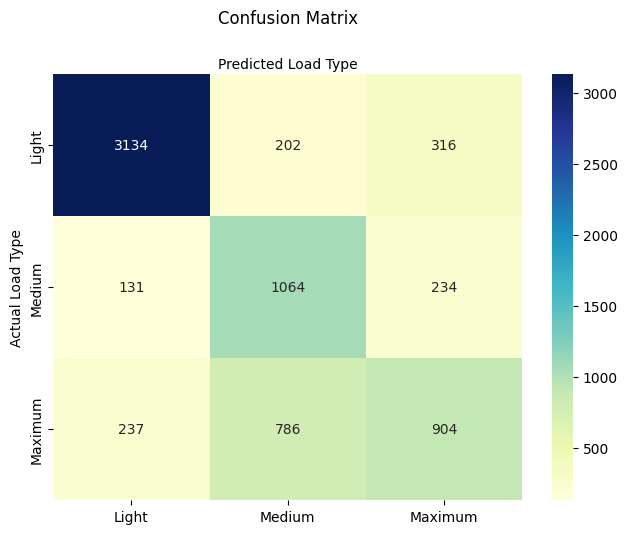

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time
from torch.utils.data import DataLoader, TensorDataset

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and prepare the data (this part stays the same as your existing code)

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# Fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')

# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

# Convert data to tensors and send to device
t_c = torch.tensor(y).to(device)
t_u = torch.tensor(X.to_numpy()).to(torch.float32).to(device)

# Split data into training and validation sets
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices].to(device)
t_c_train = t_c[train_indices].to(device)
t_u_val = t_u[val_indices].to(device)
t_c_val = t_c[val_indices].to(device)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(t_u_train, t_c_train)
val_dataset = TensorDataset(t_u_val, t_c_val)

# Create DataLoaders for both training and validation sets
batch_size = 64  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# Define the model
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear1', nn.Linear(14, 254)),
    ('hidden_activation1', nn.Tanh()),
    ('output_linear', nn.Linear(254, 3))
]))

seq_model = seq_model.to(device)  # Send model to device

# Set up the optimizer
optimizer = optim.SGD(seq_model.parameters(), lr=1e-5)

# Function to train and evaluate the model with mini-batches
def training_loop(n_epochs, optimizer, seq_model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        seq_model.train()  # Set the model to training mode
        total_train_loss = 0  # To track the training loss
        for batch_idx, (t_u_batch, t_c_batch) in enumerate(train_loader):
            t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            t_p_batch = seq_model(t_u_batch)

            # Compute loss
            loss_train = loss_fn(t_p_batch, t_c_batch)
            total_train_loss += loss_train.item()

            # Backward pass and optimization
            loss_train.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)


        # Validation loop
        seq_model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for t_u_batch, t_c_batch in val_loader:
                t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)

                # Forward pass
                t_p_batch = seq_model(t_u_batch)

                # Compute loss
                loss_val = loss_fn(t_p_batch, t_c_batch)
                total_val_loss += loss_val.item()

        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        # Print loss values at the end of each epoch
        if epoch == 1 or epoch % 10 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              time.time()-start_time, epoch, loss_train.item(), loss_val.item()))
          print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Training the model
start_time = time.time()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    seq_model=seq_model,
    loss_fn=nn.CrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader
)

# Plot training and validation loss
train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
    plt.plot(train_losses_cpu, label="Training Loss")
    plt.plot(val_losses_cpu, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()

# Evaluation: Confusion Matrix and Classification Report
seq_model.eval()

with torch.no_grad():
    t_u_val = t_u_val.to(device)
    predictions = seq_model(t_u_val)
    predicted_classes = torch.argmax(predictions, dim=1)  # Get the index of the max value in each prediction

t_c_val = t_c_val.cpu().numpy()  # Move target to CPU for evaluation
predicted_classes = predicted_classes.cpu().numpy()  # Move predictions to CPU for evaluation

# Confusion Matrix
matrix = confusion_matrix(t_c_val, predicted_classes)
report = classification_report(t_c_val, predicted_classes)
print(report)

# Plot Confusion Matrix
class_names = ['Light', 'Medium', 'Maximum']  # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", fmt='g',
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()

